In [27]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import Modules.chain_methods as cm
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.sparse import lil_matrix


%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
importlib.reload(cm)
np.set_printoptions(linewidth=300, formatter={'float': '{:.4f}'.format})


\begin{equation}
\begin{aligned}
  H 
  =&\sum_{n=0}^{N-1}\Bigl[
      \frac{\Delta_q}{2}\,\sigma^z_{n}
      +\frac{\Omega_d}{2}  \sigma^x_{n} 
      +\Delta_c\,a_n^{\dagger}a_n
      +g_\Phi\bigl(\sigma^{+}_{n}a_n+\sigma^{-}_{n}a_n^{\dagger}\bigr)
    \Bigr] \\
  \quad
    +&\sum_{n=0}^{N-2}\Bigl[e^{i\delta\phi}\left(
        -g_q  \sigma^{-}_{n}\sigma^{+}_{n+1}
        +g_c a_n a_{n+1}^{\dagger}  -\sqrt{g_qg_c}\bigl(
          \sigma^{-}_{n}a_{n+1}^{\dagger}         
         - a_{n}\sigma^{+}_{n+1} ) \right)+\text{h.c.}
      \Bigr].
\end{aligned}
\end{equation}


In [2]:
    
def H_driven_single_excitation(Δ_c, Δ_q, g_Φ, g_c, g_q, Ωd, δΦd,  N, dense=True, open_bc=True):
    dim = 2*N
    H = lil_matrix((dim, dim), dtype=np.complex128)
    H = cm.augment_with_vacuum(H).tolil() 

    def idx_vac(): return 0
    def idx_a(n):  return 1 + 2*n
    def idx_b(n):  return 1 + 2*n + 1

    for n in range(N):
        H[idx_a(n), idx_a(n)] += Δ_c  
        H[idx_b(n), idx_b(n)] += Δ_q 
        # On-site a<->b coupling g_Φ
        H[idx_a(n), idx_b(n)] += g_Φ
        H[idx_b(n), idx_a(n)] += g_Φ
        # sigma_x on the first qubit
        H[idx_b(n),idx_vac() ] += Ωd/2
        H[idx_vac(), idx_b(n)] += Ωd/2

    # Intercell terms
    phase = np.exp(1j * δΦd)
    for n in range(N-1 if open_bc else N):
        m = (n+1) % N
        
        H[idx_a(n), idx_a(m)] += g_c                * phase
        H[idx_a(m), idx_a(n)] += g_c                * phase.conj()
        
        H[idx_b(n), idx_b(m)] += -g_q               * phase
        H[idx_b(m), idx_b(n)] += -g_q               * phase.conj()
                    
        H[idx_b(n), idx_a(m)] += -np.sqrt(g_q*g_c)  * phase
        H[idx_a(m), idx_b(n)] += -np.sqrt(g_q*g_c)  * phase.conj()
        H[idx_a(n), idx_b(m)] += +np.sqrt(g_q*g_c)  * phase
        H[idx_b(m), idx_a(n)] += +np.sqrt(g_q*g_c)  * phase.conj()

    H = H.tocsr()

    if dense:
        H = np.array(H.todense())

    return H

In [3]:
cases = []
g_Φ = 0
g_c = 1 # can be any        
g_q = g_c
ω_0 = 5
 
δ= 0
cases.append([δ, ω_0, g_Φ, g_c, g_q])

δ= 2 *  g_c  
cases.append([δ, ω_0, g_Φ, g_c, g_q])

δ= 4 * g_c 
cases.append([δ, ω_0, g_Φ, g_c, g_q])

δ= 8 * g_c
cases.append([δ, ω_0, g_Φ, g_c, g_q])


cases_titles = ['$\delta/g=0$','$\delta/g=2$','$\delta/g=4$','$\delta/g=8$']

In [4]:
δ, ω_0, g_Φ, g_c, g_q = cases[1]
ω_d =  1
Δ_q =  ω_0 - δ/2 - ω_d
Δ_c =  ω_0 + δ/2 - ω_d
Ωd  = 0
δΦd = 0

In [5]:
N =10
dim = 2 * N + 1

# Initialize the Hamiltonian matrix (complex valued)
H = H_driven_single_excitation(Δ_c, Δ_q, g_Φ, g_c, g_q, Ωd, δΦd,  N, dense=True, open_bc=True)

# Diagonalize the Hamiltonian
E, ψ = np.linalg.eig(H)
E = np.real(E)
idx_sort = np.argsort(E)
E = E[idx_sort]
ψ = ψ[:, idx_sort]  

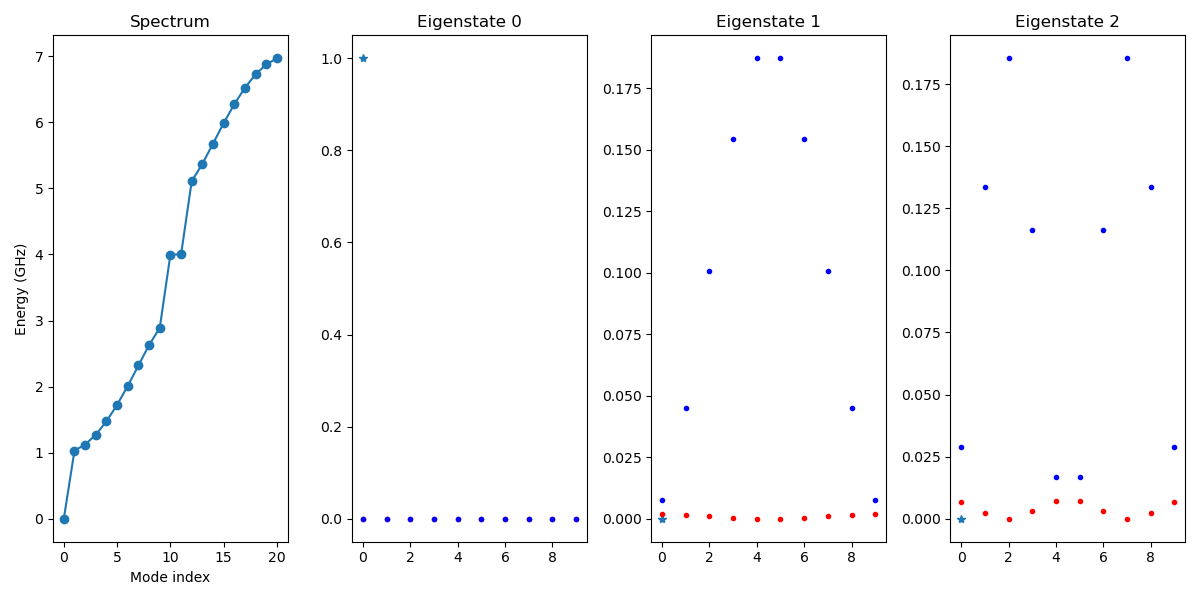

In [6]:
# Plot the eigenvalue spectrum
fig, axs = plt.subplots(ncols=4, figsize=(12,6))

axs[0].plot(np.arange(dim), E, 'o-')
axs[0].set_xlabel('Mode index')
axs[0].set_ylabel('Energy (GHz)')
axs[0].set_title('Spectrum')

for i, ax in enumerate(axs[1:]):
    ax.plot( np.square(np.abs(ψ[0,    i])),'*')
    ax.plot( np.square(np.abs(ψ[1::2, i])),'.r')
    ax.plot( np.square(np.abs(ψ[2::2, i])),'.b')
    ax.set_title(f'Eigenstate {i}')

fig.tight_layout()



In [12]:
Ωd_values = np.linspace(0, 1, 100)
E_vs_Ωd = np.zeros([len(Ωd_values), dim])
ψ_vs_Ωd = np.zeros([len(Ωd_values), dim, dim], dtype='complex')

for i, Ωd in enumerate(Ωd_values):

    H = H_driven_single_excitation(Δ_c, Δ_q, g_Φ, g_c, g_q, Ωd, δΦd,  N, dense=True, open_bc=True)
    
    E, ψ = np.linalg.eig(H)
    E = np.real(E)
    idx_sort = np.argsort(E)
    E_vs_Ωd[i] = E[idx_sort] 
    ψ_vs_Ωd[i] = ψ[:, idx_sort]


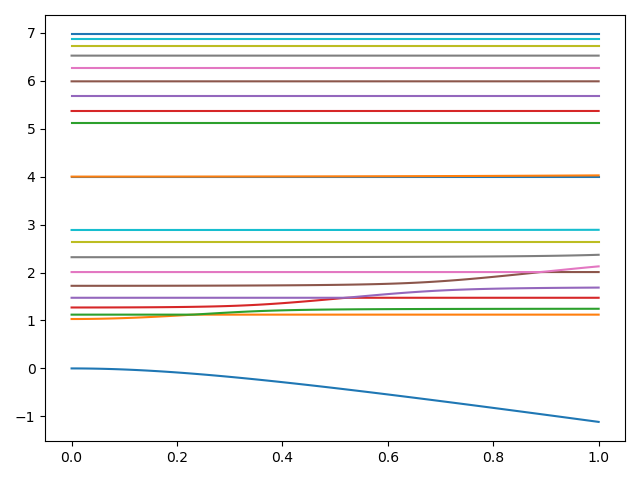

In [13]:
fig, ax = plt.subplots()

ax.plot(Ωd_values, E_vs_Ωd)

fig.tight_layout()

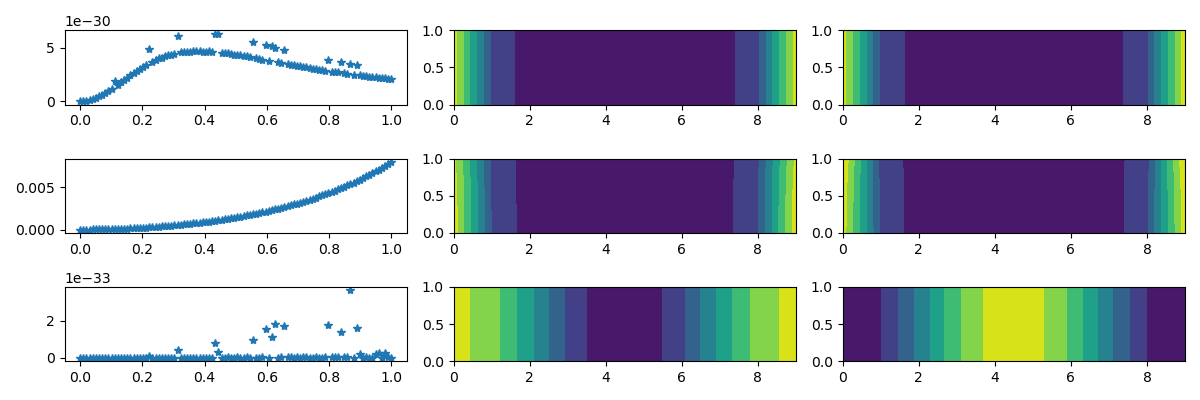

In [16]:
state_index=dim//2

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[12,4])

for i in range(3):
    axs[i, 0].plot(Ωd_values, np.square(np.abs(ψ_vs_Ωd[:, 0,    state_index+i])),'*')
    axs[i, 1].contourf(np.arange(N), Ωd_values, np.square(np.abs(ψ_vs_Ωd[:, 1::2, state_index+ i])) )
    axs[i, 2].contourf(np.arange(N), Ωd_values, np.square(np.abs(ψ_vs_Ωd[:, 2::2, state_index+ i])) )

fig.tight_layout()

# Time evolution with a driving

## Transport, driving on a single qubit for a short time

In [270]:
δ, ω_0, g_Φ, g_c, g_q = cases[1]
g_Φ=0.2
ω_d =  1
Δ_q =  ω_0 - δ/2 - ω_d
Δ_c =  ω_0 + δ/2 - ω_d
Ωd  = 0.5
δΦd = 0.5

In [271]:
N =10
dim = 2 * N + 1

# Initialize the Hamiltonian matrix (complex valued)
H = H_driven_single_excitation(Δ_c, Δ_q, g_Φ, g_c, g_q, Ωd, δΦd,  N, dense=False, open_bc=True)

In [272]:
g_scale = max(abs(g_q), abs(g_c), abs(g_Φ))
t_max   = 2*N / g_scale
T       = 2000
t_array = np.linspace(0.0, t_max, T)

In [273]:
importlib.reload(cm)
#Vacumm
psi0 = np.zeros(1+2*N, complex); psi0[0]=1

drive_site=N//2

drives = [cm.Drive(site=drive_site, Omega=1, omega=Δ_q, phi=0, t_off=t_max//10)  ]
states = cm.evolve_with_drives(H, N, drives, t_array, psi0, augment_vacumm=False)
p_vac, p_a, p_b, P_edge = cm.observables_augmented(states, N)

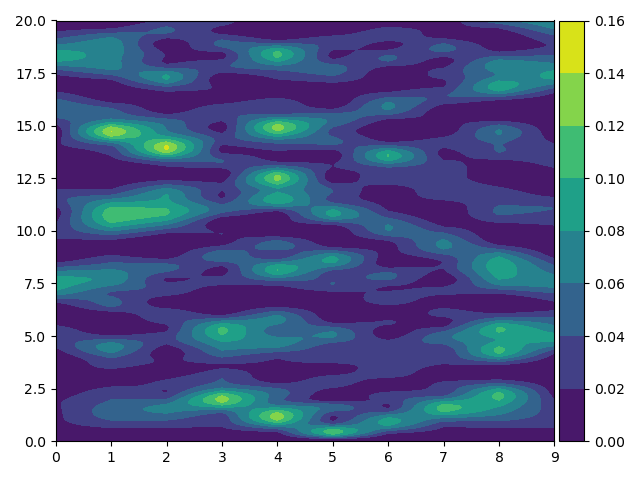

In [274]:
fig, ax = plt.subplots()
cont = ax.contourf(np.arange(N), t_array, p_b )
figs.colorbar(cont)    
fig.tight_layout()

## Driving spectroscopy

In [85]:
δ, ω_0, g_Φ, g_c, g_q = cases[1]
g_Φ=0.2
ω_d =  1
Δ_q =  ω_0 - δ/2 - ω_d
Δ_c =  ω_0 + δ/2 - ω_d
Ωd  = 0.5
δΦd = 0

In [86]:
N =10
dim = 2 * N + 1

# Initialize the Hamiltonian matrix (complex valued)
H = H_driven_single_excitation(Δ_c, Δ_q, g_Φ, g_c, g_q, Ωd, δΦd,  N, dense=False, open_bc=True)

In [87]:
E, ψ = np.linalg.eig(H.todense())
E = np.real(E)
idx_sort = np.argsort(E)
E = E[idx_sort]
ψ = ψ[:, idx_sort]  

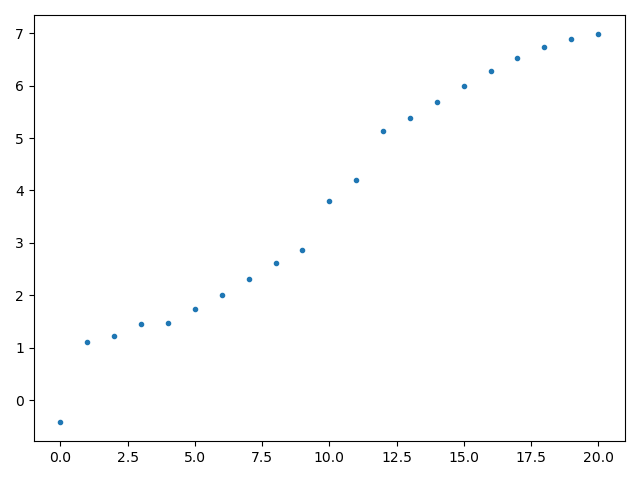

In [88]:
fig, ax = plt.subplots()

ax.plot(E,'.')

fig.tight_layout()

In [91]:
importlib.reload(cm)
j_drive = N-1
Omega = 0.05      # weak drive
omega_list = np.linspace(3.5, 4.7, 20 )  # in the same units as H0 entries
omegas, Spec = cm.evolve_drive_time_sweep(H, N, j_drive, Omega, omega_list,
                                       phi=0.0, gamma=1e-3,
                                       T_trans=100, T_avg=200,
                                       points_per_unit=50, augment_vacumm=False)

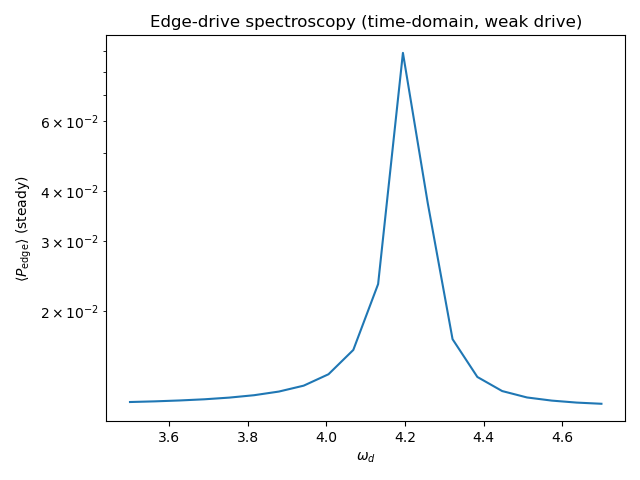

In [92]:
fig, ax = plt.subplots()

ax.plot(omegas, Spec)
ax.set_xlabel(r'$\omega_d$'); plt.ylabel(r'$\langle P_{\rm edge}\rangle$ (steady)')
ax.set_title('Edge-drive spectroscopy (time-domain, weak drive)')
# ax.vlines(eigvals,0,np.max(Spec), color='k', linewidth=0.5)
ax.set_yscale('log')
fig.tight_layout()


C:\Users\gabri\AppData\Local\Temp\ipykernel_2388\1123506242.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


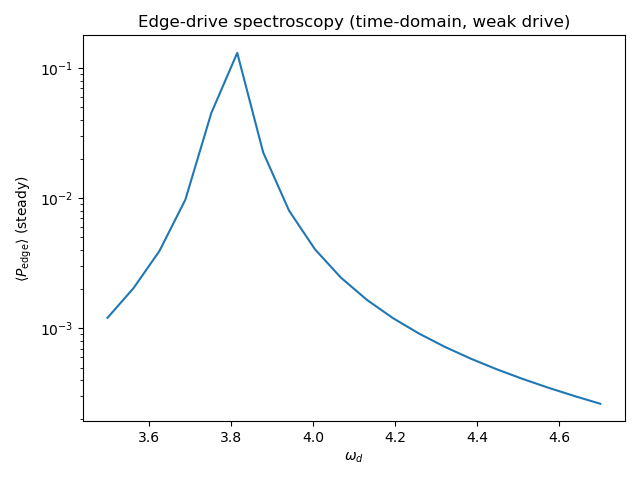

In [69]:
fig, ax = plt.subplots()

ax.plot(omegas, Spec)
ax.set_xlabel(r'$\omega_d$'); plt.ylabel(r'$\langle P_{\rm edge}\rangle$ (steady)')
ax.set_title('Edge-drive spectroscopy (time-domain, weak drive)')
# ax.vlines(eigvals,0,np.max(Spec), color='k', linewidth=0.5)
ax.set_yscale('log')
fig.tight_layout()
